In [1]:
# EXECUTING THE FOLLOWING WILL INSTALL GLOBAL DEPENDENCIES ON YOUR SYSTEM.
# ONLY RUN FOR GOOGLE COLAB INSTANCES, ETC.
# Installs Pyomo (modeling language) and IPOPT (solver). See http://www.pyomo.org/ and https://coin-or.github.io/Ipopt/.

# !pip install pyomo
# !wget -N -q "https://matematica.unipv.it/gualandi/solvers/ipopt-linux64.zip"
# !unzip -o -q ipopt-linux64

from pyomo.environ import (
    SolverFactory,
    AbstractModel,
    Param,
    RangeSet,
    Var,
    Objective,
    Constraint,
)
from pyomo.core import NonNegativeIntegers, PositiveReals, NonNegativeReals, Reals  # type: ignore

import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots as _

plt.style.use("ieee")  # Comment out if not supported

solver = SolverFactory("ipopt")

## Reservoir Stats

- Name: Curve Reservoir
- Coordinates: $36.33385606273248, -111.6578894846542$

### Old Stats (from Quinn's initial findings)

- Perimeter: $699.69$ m
- Maximum area: $19,991.22$ m^2
- Catchment area: m^2
- Elevation: $1,815$ m
- $c_1$: $30.684$
- $c_2$: $0.978$

### Updated Stats (from paper)

- Maximum area: $21,085$ m
- Catchment area: $1.6 \cdot 10^7$ m^2
- $c_1$: $1.4534$
- $c_2$: $1.1919$

## Workaround for bounding overflow

Original formulation is $w(t) = \text{max}\{v(k+1) - S, 0\}$, but Pyomo (and other solvers in general?) do not support decision variables/computations. Here's the workaround, by introducing an unbounded $w_u$ that can be negative (when $v(t + 1) < S$).

$$
\begin{align*}
    w_u(t)
    &= v(t + 1) - S \in \R \\
    w(t)
    &= \text{max}(0, w_u(t)) \in \R_{\geq 0}\\
    &= \frac12 (w_u + |w_u|)
\end{align*}
$$


In [2]:
# TODO: Change t to k, fix mutability warnings
mu = 1e-6

model = AbstractModel()

# Set `K` of period indices
model.num_periods = Param(within=NonNegativeIntegers)
model.T_periods = RangeSet(0, model.num_periods - 1)
model.T_points = RangeSet(0, model.num_periods)

# Constant parameters
model.c1 = Param(within=PositiveReals)  # Scalar constant c1 for volume
model.c2 = Param(within=PositiveReals)  # Scalar constant c2 for volume
model.A_c = Param(within=PositiveReals)  # Catchment area
model.A_max = Param(within=PositiveReals)  # Maximum surface area
model.Q_max = Param(within=NonNegativeReals)  # Maximum pumping rate
model.E_coeff = Param(within=PositiveReals)  # Evaporation coefficient

# Time-varying parameters
model.P = Param(model.T_periods, within=NonNegativeReals)  # Precipitation rate
model.E_pan = Param(model.T_periods, within=NonNegativeReals)  # Pan evaporation rate

# Time-invariant parameters
model.S_max = Param(
    initialize=model.c1 * (mu + model.A_max) ** model.c2
)  # Maximum storage capacity
model.R = Param(
    model.T_periods,
    default=lambda model, t: model.A_c * 0.3 * model.P[t],
    within=NonNegativeReals,
)  # Calculate rainfall [6]

# Optimizable variables
model.V = Var(model.T_points, domain=NonNegativeReals)  # Volume
model.S = Var(model.T_points, domain=NonNegativeReals)  # Storage
model.A = Var(model.T_points, domain=NonNegativeReals)  # Surface area
model.E = Var(model.T_periods, domain=NonNegativeReals)  # Evaporation
model.Q = Var(model.T_periods, domain=NonNegativeReals)  # Pumping
model.W = Var(model.T_periods, domain=NonNegativeReals)  # Overflow

model.unbounded_W = Var(model.T_periods, domain=Reals)  # Possibly negative overflow

# Objective
model.min_overflow = Objective(
    expr=lambda model: sum(model.W[t] for t in model.T_periods)
)  # Minimize overflow
# model.trivial = Objective(expr=lambda _: 0)  # TEMPORARY: To verify model feasibility

# Constraints
model.volume = Constraint(
    model.T_periods,
    rule=lambda model, t: model.V[t + 1]
    == model.S[t] + model.R[t] - model.E[t] - model.Q[t],
)  # Volumetric balance equation [1]

model.unbounded_overflow = Constraint(
    model.T_periods,
    rule=lambda model, t: model.unbounded_W[t] == model.V[t + 1] - model.S_max,
)  # Calculate unbounded overflow (possibly negative)

model.overflow = Constraint(
    model.T_periods,
    rule=lambda model, t: model.W[t]
    == (model.unbounded_W[t] + abs(model.unbounded_W[t]))
    / 2,  # Equivalent to max(0, model.unbounded_W[t]) [2]
)  # Calculate (bounded) overflow [2]

model.evaporation = Constraint(
    model.T_periods,
    rule=lambda model, t: model.E[t]
    == (model.A[t] + model.A[t + 1]) / 2 * model.E_coeff * model.E_pan[t],
)  # Calculate evaporation [7]

model.storage = Constraint(
    model.T_periods,
    rule=lambda model, t: model.S[t + 1] == model.V[t + 1] - model.W[t],
)  # Bound storage [3]

model.storage_to_area = Constraint(
    model.T_points,
    rule=lambda model, t: model.S[t] == model.c1 * (mu + model.A[t]) ** model.c2,
)  # Relate storage to area [4]

# model.upper_A = Constraint(
#     model.T_points, rule=lambda model, t: model.A[t] <= model.A_max
# )  # Bound surface area [5] (Redundant?)

model.upper_Q = Constraint(
    model.T_periods, rule=lambda model, t: model.Q[t] <= model.Q_max
)  # Bound pumping [8]

# model.initial_S = Constraint(rule=lambda model: model.S[0] == mu)
# model.initial_V = Constraint(rule=lambda model: model.S[6] == mu)

In [3]:
N_BARS = 4
WIDTH = 1.0 / N_BARS


def plot_model(instance: AbstractModel, debug=False) -> None:
    volume = np.array([instance.V[i].value for i in instance.T_points])
    storage = np.array([instance.S[i].value for i in instance.T_points])
    rainfall = np.array([instance.R[i] for i in instance.T_periods])
    evaporation = np.array([instance.E[i].value for i in instance.T_periods])
    pumping = np.array([instance.Q[i].value for i in instance.T_periods])
    overflow = np.array([instance.W[i].value for i in instance.T_periods])

    assert (
        np.equal(volume.shape, storage.shape)
        and np.unique(
            [rainfall.shape, evaporation.shape, pumping.shape, overflow.shape]
        ).size
        == 1
    )

    x_periods = np.arange(rainfall.size)

    if debug:
        print("Volume:", volume)
        print("Storage:", storage)
        print("Rainfall:", rainfall)
        print("Evaporation:", evaporation)
        print("Pumping:", pumping)
        print("Overflow:", overflow)

    plt.rcParams["figure.figsize"] = [8, 5]
    plt.title("Hydraulic Storage Model")
    plt.plot(
        volume, "-bo", alpha=0.5, label="Volume"
    )  # Could omit last/12-th point (volume[:-1])
    plt.plot(storage, "-ro", alpha=0.5, label="Storage")  # sim.
    plt.bar(
        x_periods,
        rainfall,
        width=WIDTH,
        color="y",
        alpha=0.5,
        label="Rainfall",
    )
    plt.bar(
        x_periods + WIDTH,
        evaporation,
        width=WIDTH,
        color="g",
        alpha=0.5,
        label="Evaporation",
    )
    plt.bar(
        x_periods + 2 * WIDTH,
        pumping,
        color="c",
        width=WIDTH,
        alpha=0.5,
        label="Pumping",
    )
    plt.bar(
        x_periods + 3 * WIDTH,
        overflow,
        width=WIDTH,
        color="m",
        alpha=0.5,
        label="Overflow",
    )
    plt.hlines(
        y=instance.S_max.value,
        xmin=0,
        xmax=instance.num_periods,
        alpha=0.5,
        linestyles="dashed",
        label="Max Storage",
    )

    plt.xlabel("Time (months 0-11)")
    plt.ylabel("Volume (m$^3$)")
    plt.legend(prop={"size": 8}, ncol=3)
    plt.show()

In [4]:
N_PERIODS = 12

PRECIP_RATE = 0.0254 * np.array(
    [0.55, 0.51, 0.59, 0.28, 0.31, 0.16, 0.67, 0.71, 0.98, 0.87, 0.43, 0.31]
)  # in/month -> m/month (m)

# Pan evporation rate (in/month)}
PAN_COEFF = 0.8
PAN_EVAP_RATE = 0.0254 * np.array(
    [
        2.45,
        2.60,
        5.84,
        8.27,
        10.72,
        12.86,
        13.06,
        11.38,
        8.42,
        5.13,
        2.29,
        2.45,
    ]
)  # in/month -> m/month (m)

C1, C2 = 1.4534, 1.1919
CATCHMENT_AREA = 1.6 * 1e7  # (m^2)
MAX_SURFACE_AREA = 21085  # (m^2)

or mutable Param).  The linkage between this RangeSet and the original source
data will be broken, so updating the data value in the future will not be
reflected in this RangeSet.  To suppress this warning, explicitly convert the
source data to a constant type (e.g., float, int, or immutable Param)


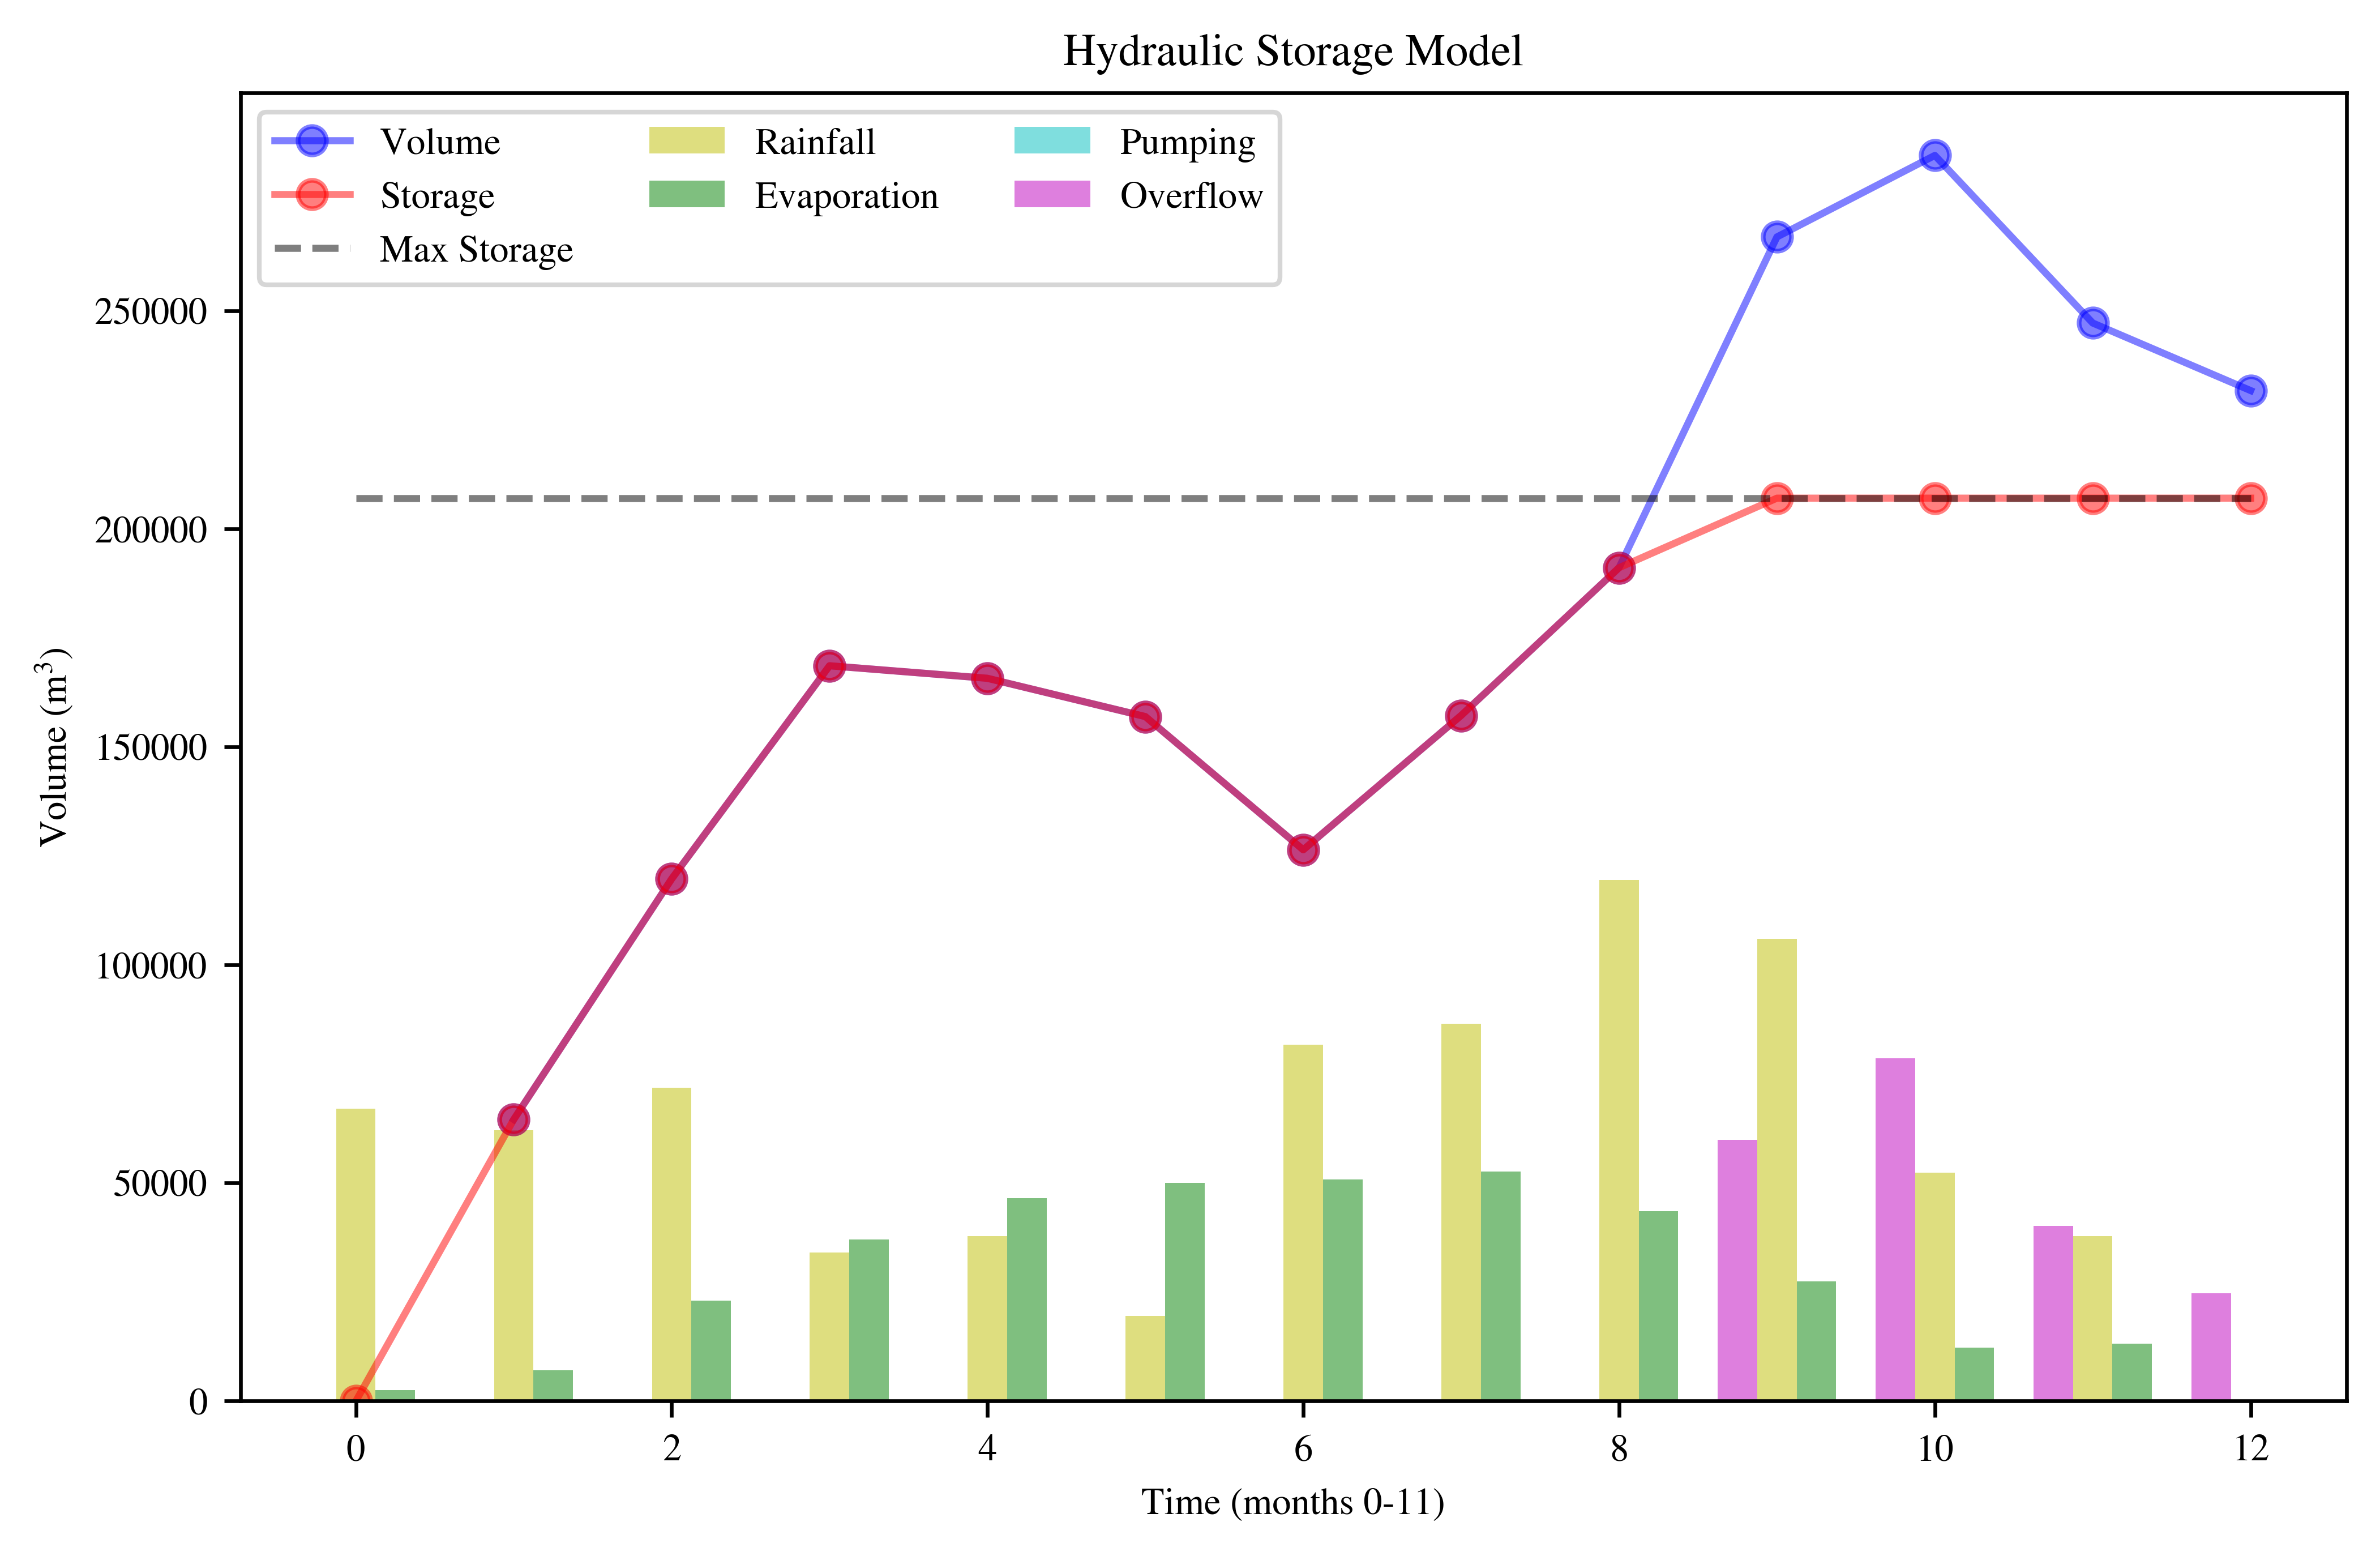

In [5]:
# ALL AREAL AND VOLUMETRIC PARAMETERS ARE IN METERS (M), TEMPORAL UNIT IS MONTHS
data = {
    None: {
        "num_periods": {None: N_PERIODS},
        "c1": {None: C1},
        "c2": {None: C2},
        "A_c": {None: CATCHMENT_AREA},
        "A_max": {None: MAX_SURFACE_AREA},
        "Q_max": {None: 0},
        "P": dict(enumerate(PRECIP_RATE)),
        "E_pan": dict(enumerate(PAN_EVAP_RATE)),
        "E_coeff": {None: 10},
    }
}

instance = model.create_instance(data)
results = solver.solve(instance)

plot_model(instance)

### Monthly Curve Fitting


In [6]:
pga_df = utils.load_mesonet(
    "/Users/quinnouyang/Desktop/Work-ish/CERG/Bodaway Gap/Water Optimization/dynamics_model/PGA_2005_2020.csv"
)
irr_df = utils.load_pvgis(
    "Water Optimization/dynamics_model/Curve_Radiation_2005_2020.csv"
)

# https://wrcc.dri.edu/Climate/comp_table_show.php?stype=pan_evap_avg
pan_m_df = pd.DataFrame(
    {
        "month": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        "evap": [
            0.00,
            2.60,
            5.84,
            8.27,
            10.72,
            12.86,
            13.06,
            11.38,
            8.42,
            5.13,
            2.29,
            0.00,
        ],
    }
)

pan_m_df["est"] = (
    0.8 * pan_m_df["evap"] * 25.4 / 30.437
)  # in/month -> mm/day (using approximate mean of days/month)

In [7]:
pga_m_df = utils.get_mean(pga_df, "valid", ["tmpc", "dwpc", "smps"], "M")
irr_m_df = utils.get_mean(irr_df, "time", ["G(i)"], "M")

res_m_df = pd.merge(
    pga_m_df,
    irr_m_df["G(i)"],
    how="inner",
    left_on="valid",
    right_on="time",
    suffixes=["_res", "_irr"],
)

res_m_df["est"] = res_m_df.apply(
    lambda row: utils.get_evaporation_rate(
        row["tmpc"], row["dwpc"], 1815, row["G(i)"], row["smps"]
    ),
    axis=1,
)

res_m_mean_df = res_m_df["est"].groupby(res_m_df["month"]).mean()

Fitted Parameters:  [ 8.68919818e-03 -4.12849150e-03  1.69750748e-05  5.11087694e-01
  6.60858637e+01 -6.07279595e+03 -1.03917413e+03  6.78645069e-02]


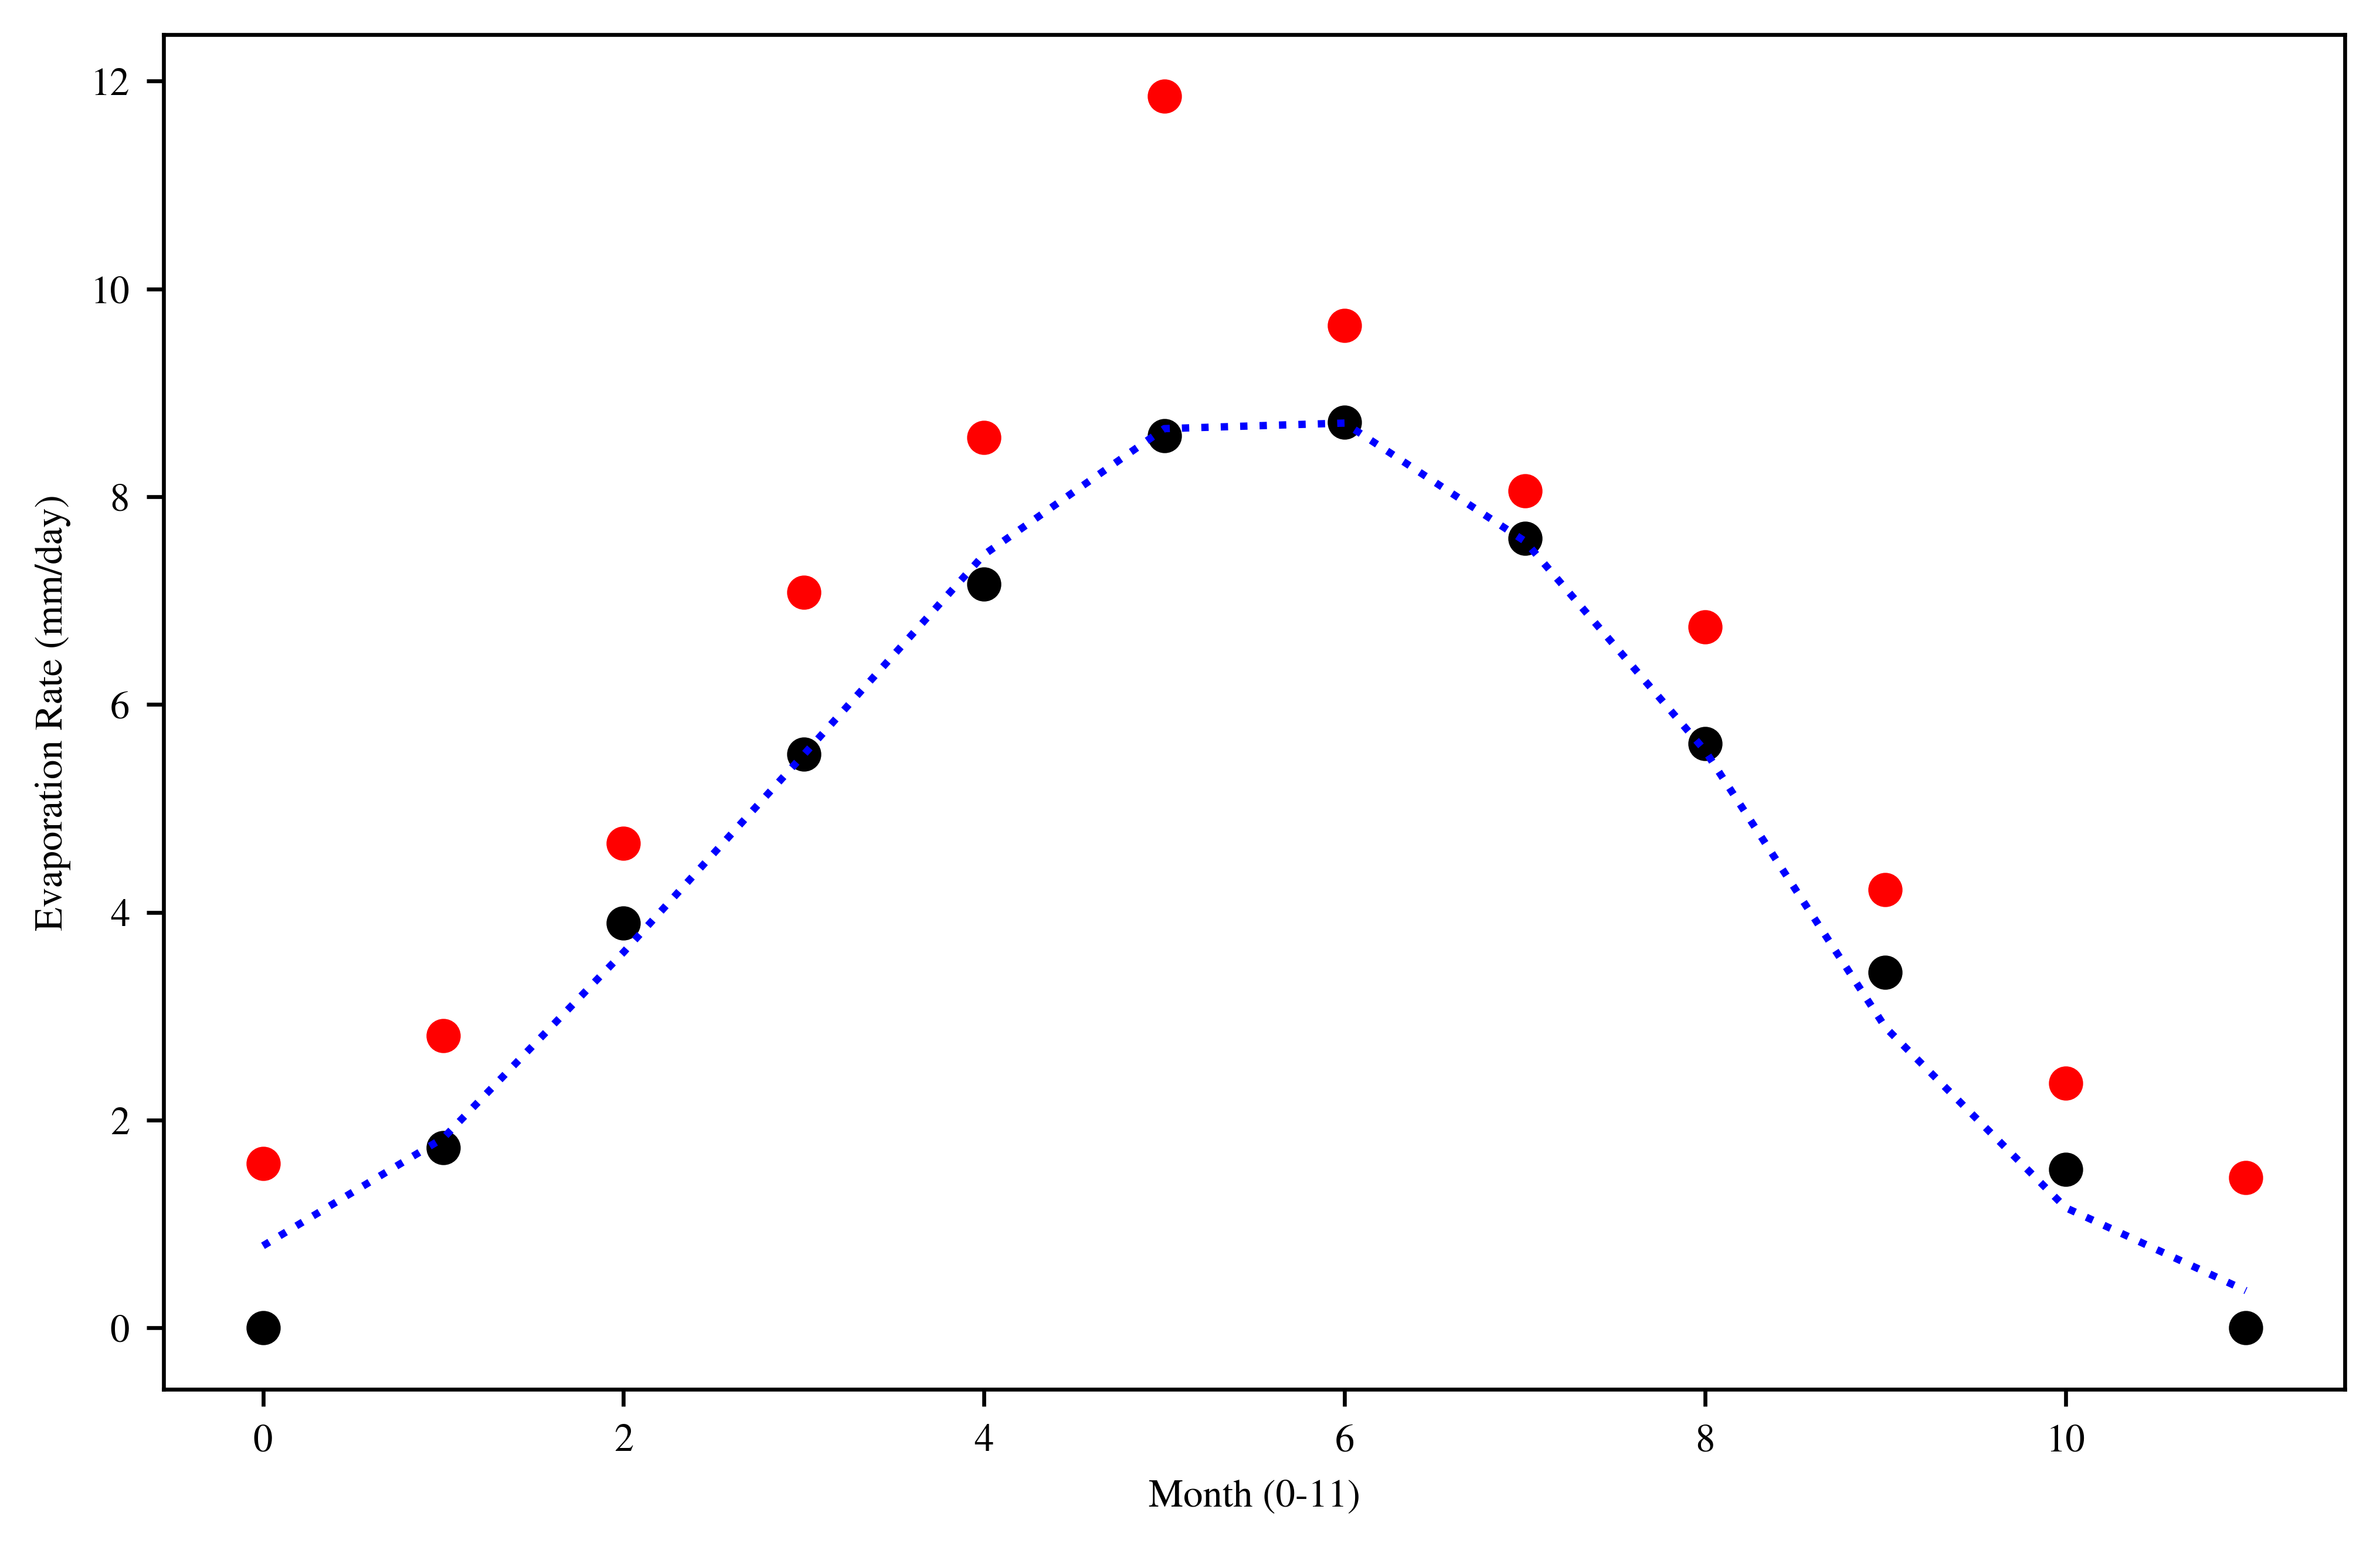

In [8]:
res_m_data = (
    res_m_df.groupby("month").mean()[["tmpc", "dwpc", "G(i)", "smps"]].to_numpy()
)
pan_m_evap = pan_m_df.est.to_numpy()
popt = utils.get_fit_parameters(res_m_data, pan_m_evap)

print("Fitted Parameters: ", popt)
plt.xlabel("Month (0-11)")
plt.ylabel("Evaporation Rate (mm/day)")
plt.plot(pan_m_df["est"].to_numpy(), "o")  # Pan estimations
plt.plot(res_m_mean_df.to_numpy(), "o")  # Model predictions
plt.plot(
    pan_m_df["month"].to_numpy() - 1,
    utils.evaporation_rate_curve(res_m_data, *popt),
    "b",
)

### Daily Interpolation


In [9]:
pga_d_df = utils.get_mean(pga_df, "valid", ["tmpc", "dwpc", "smps"], "D")
irr_d_df = utils.get_mean(irr_df, "time", ["G(i)"], "D")

res_d_df = pd.merge(
    pga_d_df,
    irr_d_df["G(i)"],
    how="inner",
    left_on="valid",
    right_on="time",
    suffixes=["_res", "_irr"],
)

evap_d_data = (
    res_d_df.groupby(["month", "day"])
    .mean()[["tmpc", "dwpc", "G(i)", "smps"]]
    .to_numpy()
)

d_evap = utils.evaporation_rate_curve(evap_d_data, *popt)
d_precip = (
    utils.get_sum(pga_df, "valid", ["p01i"], "D")
    .groupby(["month", "day"])
    .mean()["p01i"]
    .to_numpy()
)

print(d_evap.shape, d_precip.shape)

(366,) (366,)


In [10]:
d_evap[d_evap < 0] = 0
d_precip[d_precip < 0] = 0

or mutable Param).  The linkage between this RangeSet and the original source
data will be broken, so updating the data value in the future will not be
reflected in this RangeSet.  To suppress this warning, explicitly convert the
source data to a constant type (e.g., float, int, or immutable Param)


model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.12\x3a Maximum Number of Iterations
      Exceeded.


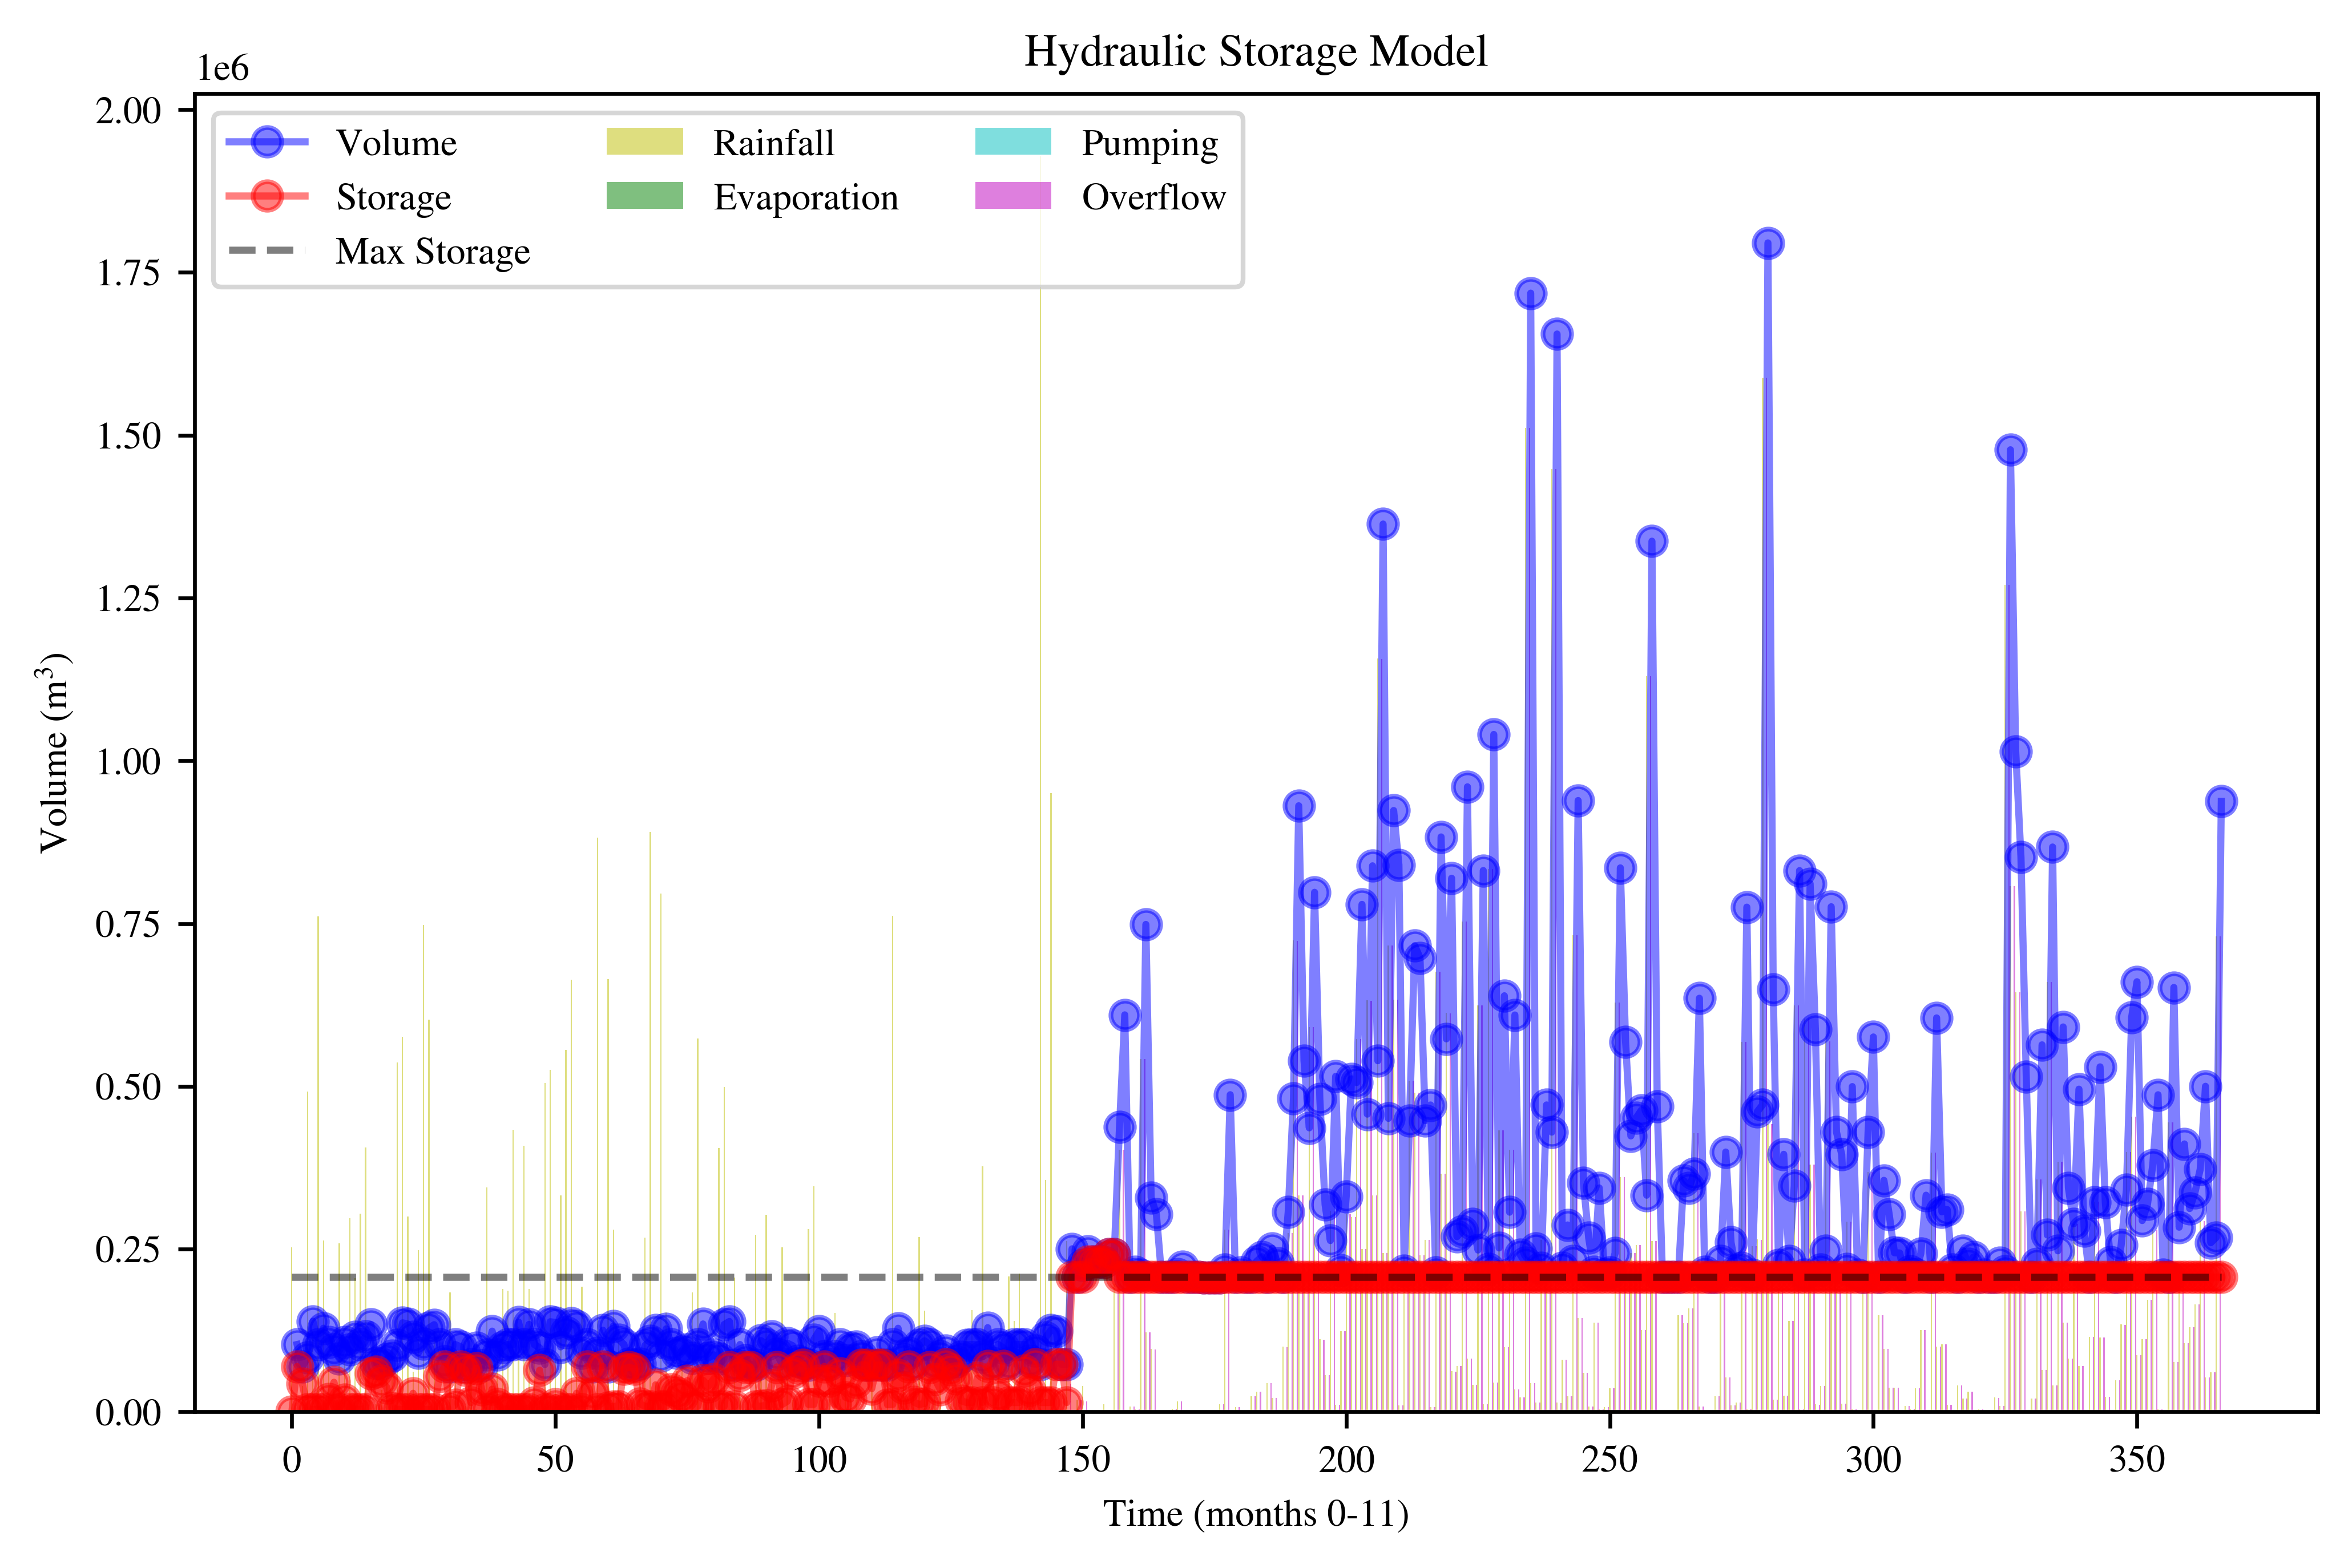

In [11]:
data = {
    None: {
        "num_periods": {None: d_evap.size},
        "c1": {None: C1},
        "c2": {None: C2},
        "A_c": {None: CATCHMENT_AREA},
        "A_max": {None: MAX_SURFACE_AREA},
        "Q_max": {None: 0},
        "P": dict(enumerate(d_precip)),
        "E_pan": dict(
            enumerate(np.concatenate((np.repeat(PAN_EVAP_RATE / 30, 30), np.zeros(6))))
        ),
        "E_coeff": {None: 0.8},
    }
}

instance = model.create_instance(data)
results = solver.solve(instance)

plot_model(instance)